In [4]:
import sys
import importlib
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting as lf

In [7]:
#for Golem
sat_14 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/sat_14.nc')
sat_15 = xr.open_dataset('/home/travis/python_code/letkf_forecasting/sat_15_good.nc')
wind_15 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/wind_15_crop.nc')
wind_15_smooth = xr.open_dataset('/home/travis/python_code/letkf_forecasting/wind_15_smooth.nc')
wind_15_ave = xr.open_dataset('/home/travis/python_code/letkf_forecasting/wind_15_ave.nc')
sensor_CI = pd.read_hdf('/home/travis/python_code/letkf_forecasting/sensor_CI.h5')
sensor_loc = pd.read_hdf('/home/travis/python_code/forecasting/current_data/sensor_loc.h5')

In [8]:
sensor_data = pd.read_hdf('/home/travis/python_code/forecasting/current_data/sensor_data.h5')

In [9]:
domain_shape = np.load('./data/domain_shape.npy')
lats = np.load('./data/lats.npy')
lons = np.load('./data/lons.npy')
cloudiness_index = pd.read_hdf('./data/cloudiness_index.h5')
clearsky = pd.read_hdf('./data/clearsky.h5')

In [10]:
pixel = pd.read_hdf('./data/pixel.h5')

In [11]:
x = np.load('./data/x.npy')
y = np.load('./data/y.npy')

In [12]:
time = pd.Timestamp('2014-04-15').tz_localize('MST')
cloudiness_15 = cloudiness_index.ix['2014-04-15']
clearsky_15 = clearsky.ix['2014-04-15']

time = pd.Timestamp('2014-04-14').tz_localize('MST')
cloudiness_14 = cloudiness_index.ix['2014-04-14']
clearsky_14 = clearsky.ix['2014-04-14']

ktm = (2.36*cloudiness_15**5 - 6.2*cloudiness_15**4 +
       6.22*cloudiness_15**3 - 2.63*cloudiness_15**2 -
       0.58*cloudiness_15 + 1)
GHI_15 = ktm*clearsky_15*(0.0001*ktm*clearsky_15 + 0.9)

ktm = (2.36*cloudiness_14**5 - 6.2*cloudiness_14**4 +
       6.22*cloudiness_14**3 - 2.63*cloudiness_14**2 -
       0.58*cloudiness_14 + 1)
GHI_14 = ktm*clearsky_14*(0.0001*ktm*clearsky_14 + 0.9)
GHI_14.index = GHI_14.index + pd.Timedelta('1day')

csi_15 = GHI_15/GHI_14

In [13]:
#This is taken from http://www.groundcontrol.com/Satellite_Look_Angle_Calculator.html
goes15_azimuth = 220.5
goes15_elevation = 44.1

time = pd.Timestamp('2014-04-15 11:00:00').tz_localize('MST')
tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')
solar_position = tus.get_solarposition(time)
lf.parallax_shift(2000,
                     goes15_azimuth,
                     goes15_elevation,
                     solar_position['azimuth'].values*np.pi/360,
                     solar_position['elevation'].values*np.pi/360)

(array([-5781.68704891]), array([-218694.14370625]))

In [16]:
importlib.reload(lf)

tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')
start_time = '2014-04-15 11:00:00' #11:00:00 is not a bad start
end_time = '2014-04-15 14:30:00' #Gets boring shortly after 14:00:00

min_cloud_height = 1000
max_cloud_height = 14000
number = 100
cloud_height_range = np.linspace(min_cloud_height, max_cloud_height, number)

RMSE = np.ones([12, number])*np.nan # 12 is number of images
lat_corrections = RMSE.copy()
lon_corrections = RMSE.copy()

dx=1000
dy=1000

count = 0
for cloud_height in cloud_height_range:
    temp_error, lat_correction, lon_correction, time_range = lf.test_parallax(
        csi_15.clip(upper=1), domain_shape, dx, dy, lats, lons, sensor_CI.clip(upper=1), sensor_loc, start_time, end_time,
        tus, cloud_height, goes15_azimuth, goes15_elevation)
    lat_corrections[:, count] = lat_correction
    lon_corrections[:, count] = lon_correction
    temp_error = temp_error**2
    this_RMSE = np.sqrt(temp_error.mean(axis=1))
    RMSE[:, count] = this_RMSE
    count += 1

10191.9191919


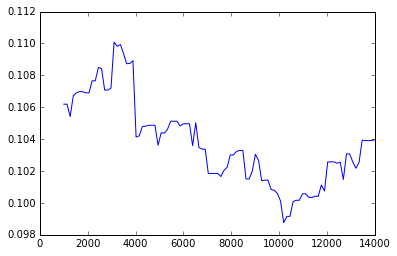

In [17]:
plt.figure()
plt.plot(cloud_height_range, RMSE.mean(axis=0))
min_height_index = RMSE.mean(axis=0).argmin()
min_height = cloud_height_range[min_height_index]
print(min_height)

In [83]:
time_range = pd.to_datetime(time_range).tz_localize('UTC').tz_convert('MST')

/home/travis/miniconda3/envs/py35Solar/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


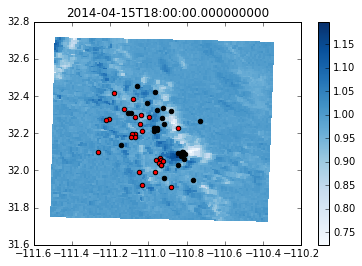

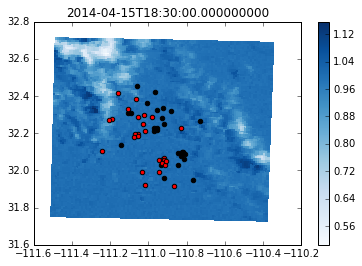

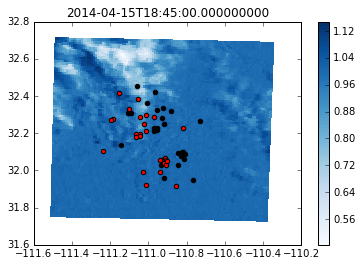

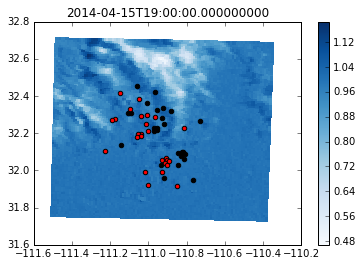

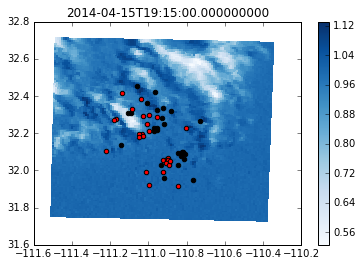

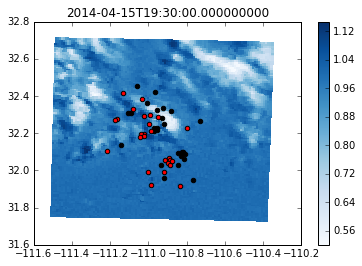

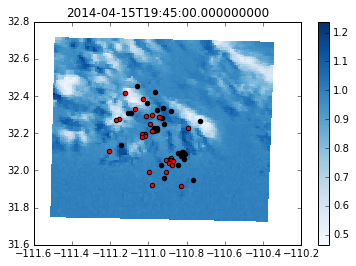

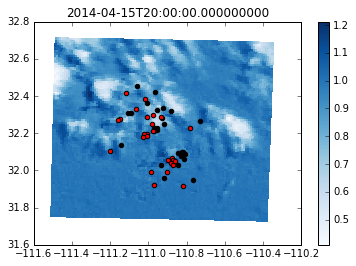

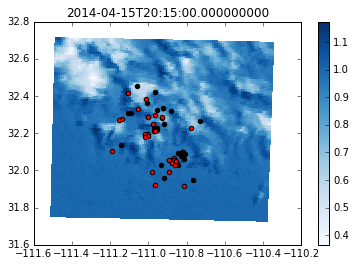

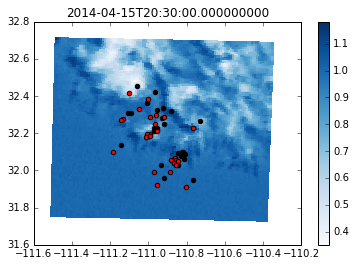

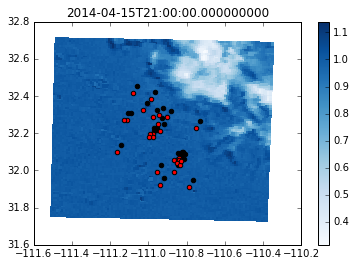

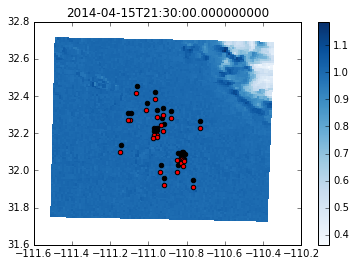

In [19]:
faction = .3
center = round(domain_shape[0]/2)
shift = round(domain_shape[0]*faction/2)
this_slice = slice(int(center - shift), int(center + shift))
these_lat_corrections = lat_corrections[:, min_height_index]
these_lon_corrections = lon_corrections[:, min_height_index]
plt_lons = lons.reshape(domain_shape)[this_slice, this_slice]
plt_lats = lats.reshape(domain_shape)[this_slice, this_slice ]
for time_index in range(time_range.size):
    time = time_range[time_index]
    
    plt.figure()
    plt.title(time)
    im = plt.pcolormesh(plt_lons, plt_lats,
                   csi_15.ix[time].reshape(domain_shape)[this_slice, this_slice ],
                   cmap='Blues')
    plt.colorbar(im)
    plt.scatter(sensor_loc['lon'], sensor_loc['lat'], c='k')
    plt.scatter(sensor_loc['lon'] + lon_corrections[time_index, min_height_index],
                sensor_loc['lat'] + lat_corrections[time_index, min_height_index],
                c='r')